Exploring:
https://kehuiyao.github.io/2019/03/21/xgboost-tuning-parameters/

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.datasets import load_svmlight_files
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from xgboost.sklearn import XGBRegressor
from scipy.sparse import vstack
from helpers.utils import *

In [9]:
seed = 123
np.random.seed(seed)

In [ ]:
DIR = "/Users/brianbroeking/projects/numerai/data"
train_static, val_static, tournament_static = load_data(DIR, reduce_memory=True)
features_list = generate_features_list(train_static)

In [7]:
X_train, y_train = clean_for_xgboost(train_static)

In [12]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [16]:
from sklearn.metrics import make_scorer
corre_score = make_scorer(correlation_score)

In [24]:
n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBRegressor(max_depth=5,
                 learning_rate=0.1,
                 n_estimators=50,
                 n_jobs=-1,
                 colsample_bytree=0.1,
                 gamma=0.2,
                 tree_method='hist'),
    X_train, y_train,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
#     cv=cv,
    scoring=corre_score
)

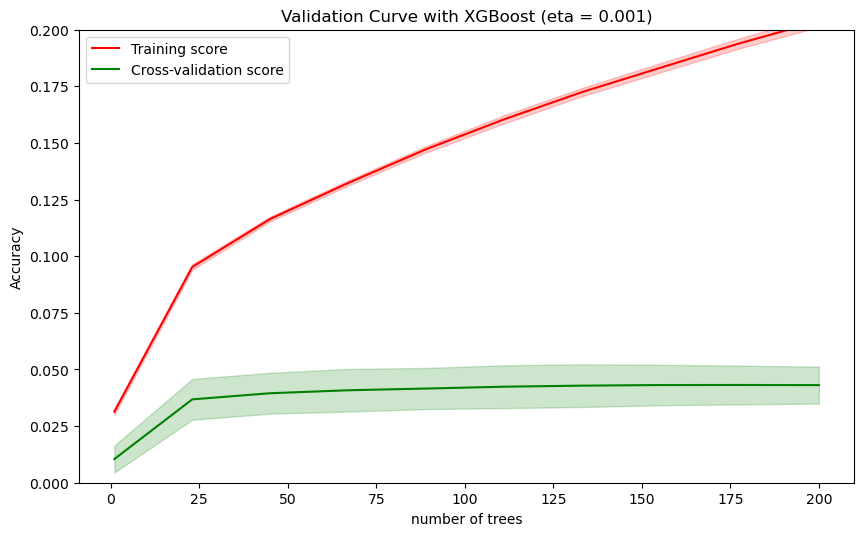

Best cross-validation result (0.04) obtained for 177 trees


In [25]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.001)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0, 0.2)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean,
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))

In [36]:
params_grid = {
    'max_depth': (2, 20),
    'learning_rate': np.linspace(1e-16, 1, 3),
    'max_depth': (4, 10),
    'min_child_weight':(14, 20),
    'gamma': (0, 1),
    'lambda': (1, 10),
    'alpha': (0, 10),
    'learning_rate': (0.001, 0.3),
}
params_fixed = {
    'objective': 'reg:squarederror',
    'n_estimators': 25,
    'colsample_bytree': 0.1,
}

In [37]:
from sklearn.model_selection import GridSearchCV
bst_grid = GridSearchCV(
    estimator=XGBRegressor(**params_fixed, seed=seed),
    param_grid=params_grid,
#     cv=cv,
    scoring=corre_score
)
bst_grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.1,
                                    gamma=None, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=25, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, seed=123,
                                    subsample=None, tree_method=None,
                        

In [33]:
bst_grid.best_params_

{'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 50}

In [38]:
bst_grid.best_params_

{'alpha': 10,
 'gamma': 0,
 'lambda': 10,
 'learning_rate': 0.3,
 'max_depth': 4,
 'min_child_weight': 14}